In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import emoji
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, SimpleRNN, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


class Preprocess:
    def remove_non_letters(self, text):
        return re.sub(r'[^a-zA-Z]', ' ', text)

    def remove_stop_words(self, text):
        stop_words = set(stopwords.words('english')) - {"never", "not", "nor"}
        tokens = nltk.word_tokenize(text)
        filtered_words = [word for word in tokens if word.lower() not in stop_words]
        return ' '.join(filtered_words)

    def normalize_words(self, text):
        return text.lower()

    def remove_short_words(self, text, min_length=2):
        return ' '.join([word for word in text.split() if len(word) >= min_length])

    def remove_long_words(self, text, max_length=15):
        return ' '.join([word for word in text.split() if len(word) <= max_length])

    def remove_twitter_handles(self, text):
        return re.sub(r'@\w+', '', text)

    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
        text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
        text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # Remove special characters and punctuation
        return text

    def remove_emoticons(self, text):
        import emoji
        return emoji.replace_emoji(text, replace='')



data = pd.read_csv('train.csv') 

PP = Preprocess()

data['cleaned_text'] = data['text'].apply(PP.remove_non_letters)
data['cleaned_text'] = data['cleaned_text'].apply(PP.remove_stop_words)
data['cleaned_text'] = data['cleaned_text'].apply(PP.normalize_words)
data['cleaned_text'] = data['cleaned_text'].apply(PP.remove_short_words)
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: PP.remove_long_words(x, 15))
data['cleaned_text'] = data['cleaned_text'].apply(PP.remove_twitter_handles)
data['cleaned_text'] = data['cleaned_text'].apply(PP.clean_text)
data['cleaned_text'] = data['cleaned_text'].apply(PP.remove_emoticons)


max_words = 10000  
max_len = 100  
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['cleaned_text'])
sequences = tokenizer.texts_to_sequences(data['cleaned_text'])


X = pad_sequences(sequences, maxlen=max_len)


y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


def build_cnn_model(input_length, vocab_size):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=input_length))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5)) 
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


def build_rnn_model(input_length, vocab_size):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=input_length))
    model.add(SimpleRNN(128, return_sequences=False))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


def build_lstm_model(input_length, vocab_size):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=input_length))
    model.add(Bidirectional(LSTM(128, return_sequences=False)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


vocab_size = len(tokenizer.word_index) + 1

# CNN
cnn_model = build_cnn_model(input_length=max_len, vocab_size=vocab_size)
cnn_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# RNN
rnn_model = build_rnn_model(input_length=max_len, vocab_size=vocab_size)
rnn_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# LSTM
lstm_model = build_lstm_model(input_length=max_len, vocab_size=vocab_size)
lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6070 - loss: 0.6574 - val_accuracy: 0.7929 - val_loss: 0.4606
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8678 - loss: 0.3548 - val_accuracy: 0.7960 - val_loss: 0.4560
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9309 - loss: 0.2177 - val_accuracy: 0.7649 - val_loss: 0.5648
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9556 - loss: 0.1389 - val_accuracy: 0.7609 - val_loss: 0.6691
Epoch 5/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9674 - loss: 0.1061 - val_accuracy: 0.7658 - val_loss: 0.8248
Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.5920 - loss: 0.6612 - val_accuracy: 0.7439 - val_loss: 0.5741
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7774 - loss: 0.4904 - val_accuracy: 0.7912 - val_loss: 0.4691
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9076 - loss: 0.2407 - val_accuracy: 0.7684 - val_lo

In [ ]:
empty_cleaned_text_rows = data[data['cleaned_text'].str.strip() == '']

print(f"Number of empty rows in 'cleaned_text': {len(empty_cleaned_text_rows)}")

Number of empty rows in 'cleaned_text': 0


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


cnn_predictions = cnn_model.predict(X_test).round()
rnn_predictions = rnn_model.predict(X_test).round()
lstm_predictions = lstm_model.predict(X_test).round()


cnn_accuracy = accuracy_score(y_test, cnn_predictions)
cnn_precision = precision_score(y_test, cnn_predictions, average='weighted')
cnn_recall = recall_score(y_test, cnn_predictions, average='weighted')
cnn_f1 = f1_score(y_test, cnn_predictions, average='weighted')


rnn_accuracy = accuracy_score(y_test, rnn_predictions)
rnn_precision = precision_score(y_test, rnn_predictions, average='weighted')
rnn_recall = recall_score(y_test, rnn_predictions, average='weighted')
rnn_f1 = f1_score(y_test, rnn_predictions, average='weighted')


lstm_accuracy = accuracy_score(y_test, lstm_predictions)
lstm_precision = precision_score(y_test, lstm_predictions, average='weighted')
lstm_recall = recall_score(y_test, lstm_predictions, average='weighted')
lstm_f1 = f1_score(y_test, lstm_predictions, average='weighted')


evaluation_df = pd.DataFrame({
    'Model': ['CNN', 'RNN', 'LSTM'],
    'Accuracy': [cnn_accuracy, rnn_accuracy, lstm_accuracy],
    'Precision': [cnn_precision, rnn_precision, lstm_precision],
    'Recall': [cnn_recall, rnn_recall, lstm_recall],
    'F1 Score': [cnn_f1, rnn_f1, lstm_f1]
})


evaluation_df = pd.DataFrame({
    'Model': ['CNN', 'RNN', 'LSTM'],
    'Accuracy': [cnn_accuracy, rnn_accuracy, lstm_accuracy],
    'Precision': [cnn_precision, rnn_precision, lstm_precision],
    'Recall': [cnn_recall, rnn_recall, lstm_recall],
    'F1 Score': [cnn_f1, rnn_f1, lstm_f1]
})


print(evaluation_df)

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
  Model  Accuracy  Precision    Recall  F1 Score
0   CNN  0.765762   0.764476  0.765762  0.764080
1   RNN  0.754378   0.755092  0.754378  0.754683
2  LSTM  0.740806   0.739943  0.740806  0.740262


In [ ]:
import numpy as np

def load_glove_embeddings(glove_file, word_index, embedding_dim):
    """Loads GloVe embeddings from a file and creates an embedding matrix.

    Args:
        glove_file (str): Path to the GloVe embeddings file.
        word_index (dict): Dictionary mapping words to their indices.
        embedding_dim (int): Dimension of the GloVe embeddings.

    Returns:
        numpy.ndarray: Embedding matrix.
    """
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    num_words = len(word_index) + 1
    embedding_matrix = np.zeros((num_words, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GRU, LSTM, Bidirectional
from tensorflow.keras.regularizers import l2
import gensim.downloader as api


glove_model = api.load('glove-wiki-gigaword-300')


max_words = 10000
max_len = 100
embedding_dim = 300  
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['cleaned_text'])
sequences = tokenizer.texts_to_sequences(data['cleaned_text'])
X = pad_sequences(sequences, maxlen=max_len)


vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in glove_model:
        embedding_matrix[i] = glove_model[word]


y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# CNN Model
def build_cnn_model(input_length, vocab_size, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length, weights=[embedding_matrix], trainable=False))
    model.add(Conv1D(128, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling1D(5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


import tensorflow as tf

class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.U = tf.keras.layers.Dense(1)

    def call(self, inputs):
        score = tf.nn.tanh(self.W(inputs))
        attention_weights = tf.nn.softmax(self.U(score), axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

# RNN with GRU and Attention
def build_gru_attention_model(input_length, vocab_size, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length, weights=[embedding_matrix], trainable=False))
    model.add(GRU(128, return_sequences=True))
    model.add(Attention(128))  # Custom attention layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# LSTM Model
def build_lstm_model(input_length, vocab_size, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length, weights=[embedding_matrix], trainable=False))
    model.add(Bidirectional(LSTM(256, return_sequences=False)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


cnn_model = build_cnn_model(input_length=max_len, vocab_size=vocab_size, embedding_matrix=embedding_matrix)
cnn_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


gru_model = build_gru_attention_model(input_length=max_len, vocab_size=vocab_size, embedding_matrix=embedding_matrix)
gru_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


lstm_model = build_lstm_model(input_length=max_len, vocab_size=vocab_size, embedding_matrix=embedding_matrix)
lstm_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


models = {'CNN': cnn_model, 'GRU_Attention': gru_model, 'LSTM': lstm_model}

for name, model in models.items():
    predictions = model.predict(X_test).round()
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')

    print(f'{name} Model:')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print('---' * 10)


[==================================================] 100.0% 376.1/376.1MB downloaded
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6971 - loss: 1.5574 - val_accuracy: 0.8050 - val_loss: 0.5613
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8101 - loss: 0.5373 - val_accuracy: 0.8083 - val_loss: 0.5319
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8241 - loss: 0.5062 - val_accuracy: 0.8109 - val_loss: 0.5378
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8546 - loss: 0.4786 - val_accuracy: 0.8096 - val_loss: 0.5608
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8694 - loss: 0.4549 - val_accuracy: 0.8070 - val_loss: 0.5685
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8913 - loss: 0.4386 - val_accuracy: 0.7663 - val_loss: 0.6709
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8764 - loss: 0.4586 - val_accuracy: 0.7912 - val_loss: 0.6265
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8988 - loss: 0.4275 - val_accuracy: 0.7991 - val_loss: 0.6459
Ep

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
CNN Classification Report
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       874
           1       0.80      0.68      0.74       649

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



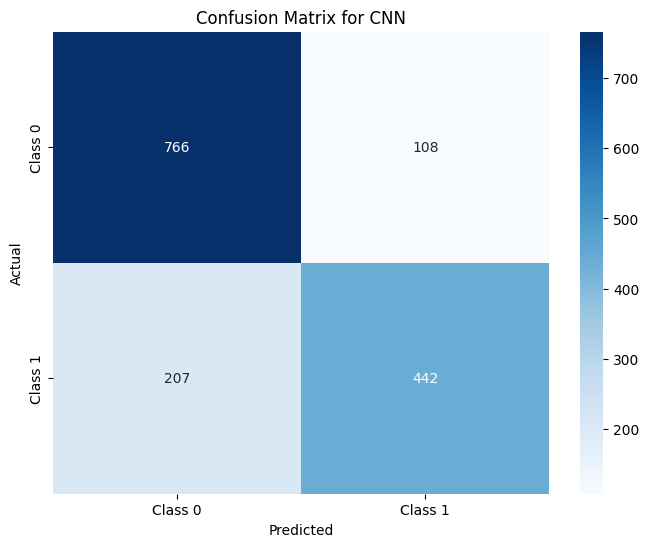

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
GRU with Attention Classification Report
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       874
           1       0.81      0.72      0.76       649

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



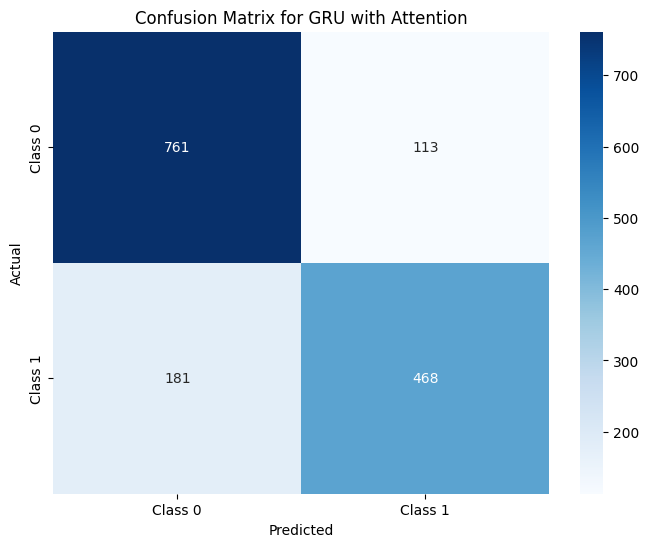

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
LSTM Classification Report
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       874
           1       0.79      0.69      0.74       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



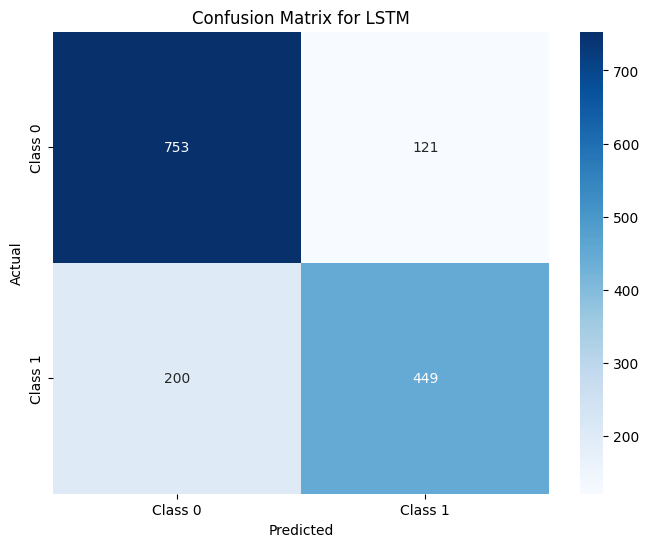

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


y_pred_cnn = cnn_model.predict(X_test).round().astype(int)


print("CNN Classification Report")
print(classification_report(y_test, y_pred_cnn))


cm = confusion_matrix(y_test, y_pred_cnn)


plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix for CNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


y_pred_gru = gru_model.predict(X_test).round().astype(int)
print("GRU with Attention Classification Report")
print(classification_report(y_test, y_pred_gru))

cm_gru = confusion_matrix(y_test, y_pred_gru)
plt.figure(figsize=(8,6))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix for GRU with Attention')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

y_pred_lstm = lstm_model.predict(X_test).round().astype(int)
print("LSTM Classification Report")
print(classification_report(y_test, y_pred_lstm))

cm_lstm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(8,6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix for LSTM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


def sentiwordnet_score(text):
    tokens = word_tokenize(text)
    sentiment_score = 0
    count = 0
    for word in tokens:
        pos = get_wordnet_pos(word)
        synsets = list(swn.senti_synsets(word, pos))
        if synsets:
            senti_synset = synsets[0]
            sentiment_score += senti_synset.pos_score() - senti_synset.neg_score()
            count += 1
    return sentiment_score / count if count != 0 else 0



data['sentiment_score'] = data['cleaned_text'].apply(sentiwordnet_score)

sequences = tokenizer.texts_to_sequences(data['cleaned_text'])
X_text = pad_sequences(sequences, maxlen=max_len)


X_sentiment = np.array(data['sentiment_score']).reshape(-1, 1)


X = np.concatenate([X_text, X_sentiment], axis=1)


y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def build_cnn_model(input_length, vocab_size, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length, weights=[embedding_matrix], trainable=False))
    model.add(Conv1D(128, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling1D(5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


cnn_model = build_cnn_model(input_length=max_len + 1, vocab_size=vocab_size, embedding_matrix=embedding_matrix)


cnn_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


gru_model = build_gru_attention_model(input_length=max_len + 1, vocab_size=vocab_size, embedding_matrix=embedding_matrix) # Added + 1 to input_length
gru_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


lstm_model = build_lstm_model(input_length=max_len + 1, vocab_size=vocab_size, embedding_matrix=embedding_matrix) # Added + 1 to input_length
lstm_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))



models = {'CNN': cnn_model, 'GRU_Attention': gru_model, 'LSTM': lstm_model}

for name, model in models.items():
    predictions = model.predict(X_test).round()
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')

    print(f'{name} Model:')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print('---' * 10)



[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6869 - loss: 1.5282 - val_accuracy: 0.8234 - val_loss: 0.5349
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8180 - loss: 0.5222 - val_accuracy: 0.8135 - val_loss: 0.5167
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8290 - loss: 0.4994 - val_accuracy: 0.8234 - val_loss: 0.5228
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8567 - loss: 0.4666 - val_accuracy: 0.8129 - val_loss: 0.5392
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8655 - loss: 0.4594 - val_accuracy: 0.8011 - val_loss: 0.5785
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8551 - loss: 0.4663 - val_accuracy: 0.8017 - val_loss: 0.5851
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8866 - loss: 0.4230 - val_accuracy: 0.8102 - val_loss: 0.5887
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9130 - loss: 0.3918 - val_accuracy: 0.8116 - val_loss: 0.6052
Ep

In [ ]:
import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


def sentiwordnet_score(text):
    tokens = word_tokenize(text)
    sentiment_score = 0
    count = 0
    for word in tokens:
        pos = get_wordnet_pos(word)
        synsets = list(swn.senti_synsets(word, pos))
        if synsets:
            senti_synset = synsets[0]
            sentiment_score += senti_synset.pos_score() - senti_synset.neg_score()
            count += 1
    return sentiment_score / count if count != 0 else 0


[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
data['sentiment_score'] = data['cleaned_text'].apply(sentiwordnet_score)

In [ ]:
max_words = 10000
max_len = 100
embedding_dim = 300  
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['cleaned_text'])
sequences = tokenizer.texts_to_sequences(data['cleaned_text'])
X_text = pad_sequences(sequences, maxlen=max_len)


X_sentiment = np.array(data['sentiment_score']).reshape(-1, 1)
X = np.concatenate([X_text, X_sentiment], axis=1)


y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
def build_cnn_model(input_length, vocab_size, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length, weights=[embedding_matrix], trainable=False))
    model.add(Conv1D(128, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling1D(5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


cnn_model = build_cnn_model(input_length=max_len + 1, vocab_size=vocab_size, embedding_matrix=embedding_matrix)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
cnn_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

gru_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

lstm_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.6952 - loss: 1.6329 - val_accuracy: 0.8218 - val_loss: 0.5948
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8188 - loss: 0.5559 - val_accuracy: 0.8030 - val_loss: 0.5592
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8457 - loss: 0.4959 - val_accuracy: 0.8126 - val_loss: 0.5419
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8664 - loss: 0.4678 - val_accuracy: 0.8130 - val_loss: 0.5678
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8709 - loss: 0.4639 - val_accuracy: 0.7811 - val_loss: 0.6382
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8827 - loss: 0.4598 - val_accuracy: 0.7947 - val_loss: 0.6417
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9172 - loss: 0.4000 - val_accuracy: 0.8017 - val_loss: 0.6535
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9241 - loss: 0.3886 - val_accuracy: 0.7990 - val_loss

In [ ]:

models = {'CNN': cnn_model, 'GRU_Attention': gru_model, 'LSTM': lstm_model}

for name, model in models.items():
    predictions = model.predict(X_test).round()
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')

    print(f'{name} Model:')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print('---' * 10)


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
CNN Model:
Accuracy: 0.771891418563923
Precision: 0.7761735977124773
Recall: 0.771891418563923
F1 Score: 0.7729133002028703
------------------------------
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
GRU_Attention Model:
Accuracy: 0.8279334500875657
Precision: 0.827572505066975
Recall: 0.8279334500875657
F1 Score: 0.8276946445100407
------------------------------
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
LSTM Model:
Accuracy: 0.8380035026269702
Precision: 0.8392808651709952
Recall: 0.8380035026269702
F1 Score: 0.8361269058757638
------------------------------


In [ ]:
import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from flair.models import TextClassifier
from flair.data import Sentence
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


flair_sentiment_model = TextClassifier.load('en-sentiment')


def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


def sentiwordnet_score(text):
    tokens = word_tokenize(text)
    sentiment_score = 0
    count = 0
    for word in tokens:
        pos = get_wordnet_pos(word)
        synsets = list(swn.senti_synsets(word, pos))
        if synsets:
            senti_synset = synsets[0]
            sentiment_score += senti_synset.pos_score() - senti_synset.neg_score()
            count += 1
    return sentiment_score / count if count != 0 else 0


def flair_sentiment(text):
    sentence = Sentence(text)
    flair_sentiment_model.predict(sentence)
    sentiment = sentence.labels[0].value
    return 1 if sentiment == 'POSITIVE' else -1  


data['sentiwordnet_score'] = data['cleaned_text'].apply(sentiwordnet_score)
data['flair_score'] = data['cleaned_text'].apply(flair_sentiment)


max_words = 10000
max_len = 100
embedding_dim = 300  # GloVe embedding dimension
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['cleaned_text'])
sequences = tokenizer.texts_to_sequences(data['cleaned_text'])
X_text = pad_sequences(sequences, maxlen=max_len)


X_sentiment = np.array(data[['sentiwordnet_score', 'flair_score']])
X = np.concatenate([X_text, X_sentiment], axis=1)


y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

def build_cnn_model(input_length, vocab_size, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length, weights=[embedding_matrix], trainable=False))
    model.add(Conv1D(128, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling1D(5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


def build_cnn_model(input_length, vocab_size, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length, weights=[embedding_matrix], trainable=False))
    model.add(Conv1D(128, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling1D(5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


cnn_model = build_cnn_model(input_length=max_len + 2, vocab_size=embedding_matrix.shape[0], embedding_matrix=embedding_matrix)



cnn_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
gru_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
lstm_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


models = {'CNN': cnn_model, 'GRU_Attention': gru_model, 'LSTM': lstm_model}

for name, model in models.items():
    predictions = model.predict(X_test).round()
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')

    print(f'{name} Model:')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print('---' * 10)


[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


2024-09-17 20:44:21,762 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmp76i_0tpp


100%|██████████| 253M/253M [00:16<00:00, 16.0MB/s]

2024-09-17 20:44:38,888 copying /tmp/tmp76i_0tpp to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2024-09-17 20:44:39,091 removing temp file /tmp/tmp76i_0tpp


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7005 - loss: 1.6174 - val_accuracy: 0.8104 - val_loss: 0.5973
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8156 - loss: 0.5543 - val_accuracy: 0.8187 - val_loss: 0.5248
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8329 - loss: 0.5011 - val_accuracy: 0.8161 - val_loss: 0.5281
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8520 - loss: 0.4699 - val_accuracy: 0.8253 - val_loss: 0.5512
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8629 - loss: 0.4694 - val_accuracy: 0.8065 - val_loss: 0.5742
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8930 - loss: 0.4303 - val_accuracy: 0.8047 - val_loss: 0.5940
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9089 - loss: 0.4054 - val_accuracy: 0.8017 - val_loss: 0.6203
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9238 - loss: 0.3866 - val_accuracy: 0.8017 - val_loss: 0.6459
Ep

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
CNN Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.77      0.80      1318
           1       0.71      0.79      0.75       966

    accuracy                           0.78      2284
   macro avg       0.77      0.78      0.77      2284
weighted avg       0.78      0.78      0.78      2284

CNN Confusion Matrix:
 [[1009  309]
 [ 204  762]]


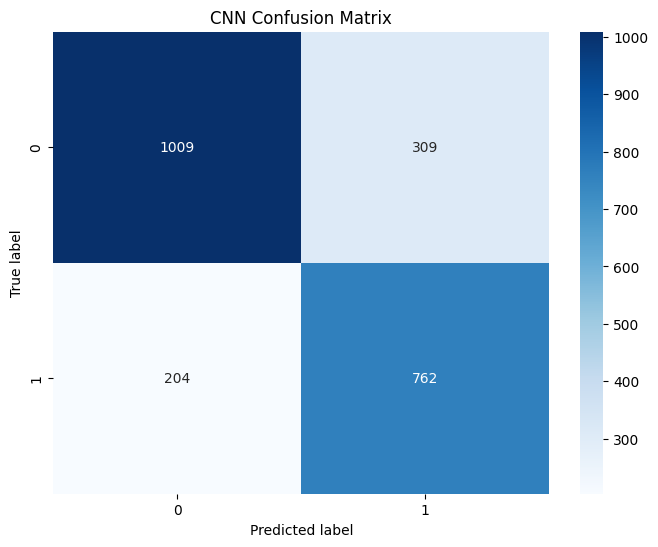

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
GRU_Attention Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.84      1318
           1       0.80      0.72      0.76       966

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.80      2284
weighted avg       0.80      0.80      0.80      2284

GRU_Attention Confusion Matrix:
 [[1138  180]
 [ 267  699]]


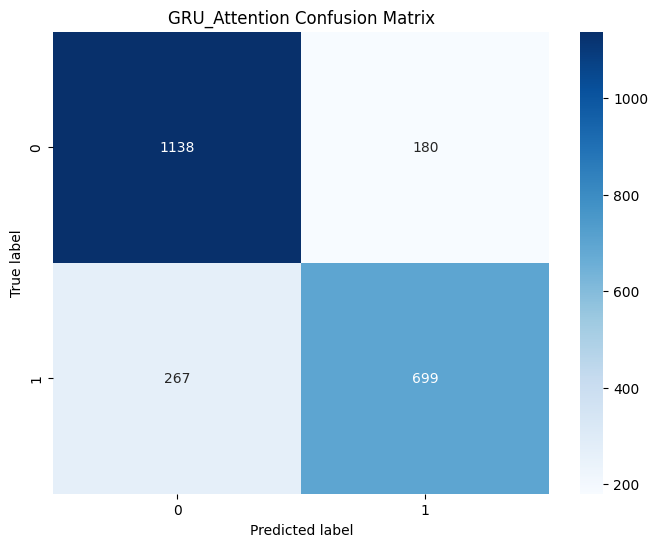

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.85      1318
           1       0.81      0.79      0.80       966

    accuracy                           0.83      2284
   macro avg       0.83      0.83      0.83      2284
weighted avg       0.83      0.83      0.83      2284

LSTM Confusion Matrix:
 [[1136  182]
 [ 204  762]]


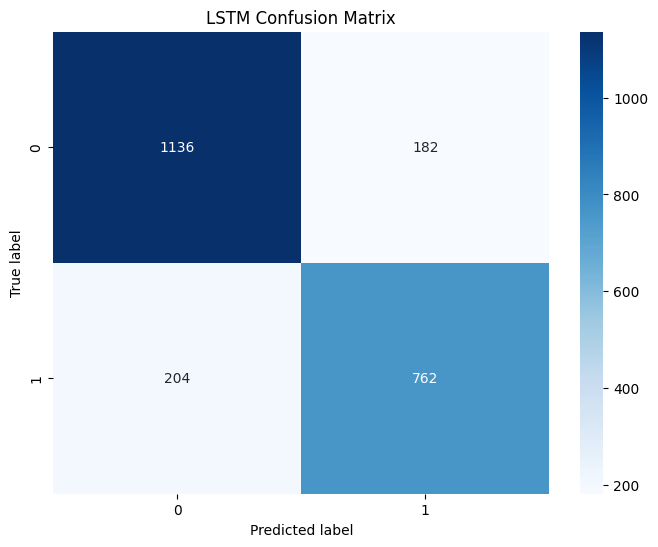

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test).round()


    report = classification_report(y_test, predictions, digits=2)
    print(f'{model_name} Classification Report:\n', report)


    cm = confusion_matrix(y_test, predictions)
    print(f'{model_name} Confusion Matrix:\n', cm)


    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


for name, model in models.items():
    evaluate_model(model, X_test, y_test, name)

